<a href="https://colab.research.google.com/github/mamunm/iamge_caption_generator/blob/main/notebooks/Attention_Models_Flicker30k_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pickle5

In [ ]:
!pip install nltk

In [ ]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
import numpy as np 
import pandas as pd

from PIL import Image
import pickle5 as pickle
import time

from nltk.translate.bleu_score import corpus_bleu
import re

In [ ]:
# Model settings
NAME = 'Flicker30k' # Flicker30k
IMAGE_MODEL = 'vgg16'
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
top_k = 10000
vocab_size = top_k + 1
num_steps = 400 if NAME == 'COCO' else 160 
features_shape = 512 if IMAGE_MODEL == 'vgg16' else 2048 #2048 for inception_v3
attention_features_shape = 81 if IMAGE_MODEL == 'vgg16' else 64 #64 for inception_v3
max_length = 45 if NAME == 'COCO' else 75

In [ ]:
# Load the numpy files
def load_data(batch, data='COCO', im_model='vgg16'):
    if data == 'COCO':
        root = '/content/drive/MyDrive/image_captioning_data/COCO/train_vectors/'
    else:
        root = '/content/drive/MyDrive/image_captioning_data/Flicker30k/train_vectors/'
    query = root + '*_{}_*_X_y_{:04d}_*'.format(im_model, batch)
    f_path = glob(query)
    data = np.load(f_path[0], allow_pickle=True)[()]
    return data['X'].numpy(), data['y']

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
      super(BahdanauAttention, self).__init__()
      self.W1 = tf.keras.layers.Dense(units)
      self.W2 = tf.keras.layers.Dense(units)
      self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
      hidden_with_time_axis = tf.expand_dims(hidden, 1)
      attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
      score = self.V(attention_hidden_layer)
      attention_weights = tf.nn.softmax(score, axis=1)
      context_vector = attention_weights * features
      context_vector = tf.reduce_sum(context_vector, axis=1)
      return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/image_captioning_data/{NAME}/Checkpoints/{NAME + '_' + IMAGE_MODEL}"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=30)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
with open(f'/content/drive/MyDrive/image_captioning_data/{NAME}/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

In [ ]:
loss_plot = []
EPOCHS = 20
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    for batch in range(1, num_steps+1):
        img_tensor, target = load_data(batch, data=NAME, im_model=IMAGE_MODEL)
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 100 Loss 2.8507
Epoch 1 Loss 2.448464
Time taken for 1 epoch 842.88 sec

Epoch 2 Batch 100 Loss 2.4130
Epoch 2 Loss 2.034829
Time taken for 1 epoch 32.90 sec

Epoch 3 Batch 100 Loss 2.1755
Epoch 3 Loss 1.825719
Time taken for 1 epoch 32.40 sec

Epoch 4 Batch 100 Loss 2.0522
Epoch 4 Loss 1.705403
Time taken for 1 epoch 32.79 sec

Epoch 5 Batch 100 Loss 1.9431
Epoch 5 Loss 1.611512
Time taken for 1 epoch 32.70 sec

Epoch 6 Batch 100 Loss 1.8434
Epoch 6 Loss 1.528783
Time taken for 1 epoch 33.73 sec

Epoch 7 Batch 100 Loss 1.7573
Epoch 7 Loss 1.457013
Time taken for 1 epoch 34.16 sec

Epoch 8 Batch 100 Loss 1.6874
Epoch 8 Loss 1.385832
Time taken for 1 epoch 32.71 sec

Epoch 9 Batch 100 Loss 1.5900
Epoch 9 Loss 1.316792
Time taken for 1 epoch 32.78 sec

Epoch 10 Batch 100 Loss 1.5048
Epoch 10 Loss 1.254324
Time taken for 1 epoch 32.72 sec

Epoch 11 Batch 100 Loss 1.4368
Epoch 11 Loss 1.179780
Time taken for 1 epoch 33.39 sec

Epoch 12 Batch 100 Loss 1.3418
Epoch 12 Loss 1.09

In [ ]:
df_loss = pd.DataFrame({'loss': [i.numpy() for i in loss_plot], 'epoch': np.arange(1, 21)})

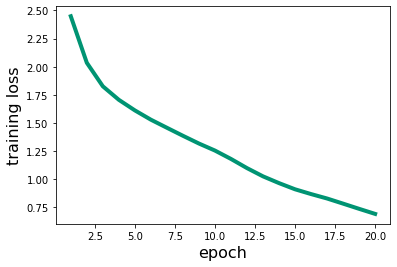

In [ ]:
sns.lineplot(data=df_loss, x='epoch', y='loss', color='#009473', linewidth=4)
plt.xlabel('epoch', fontsize=16)
plt.ylabel('training loss', fontsize=16)
plt.savefig(f'/content/drive/MyDrive/image_captioning_data/{NAME}/{NAME}_{IMAGE_MODEL}.png')

In [ ]:
def evaluate(img_tensor_val):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/184256548.jpg
Real Caption: <start> a man in a black coat and blue shirt is talking on his phone indoors <end>
Prediction Caption: a woman with short sleeved blue jacket painting a picture <end>


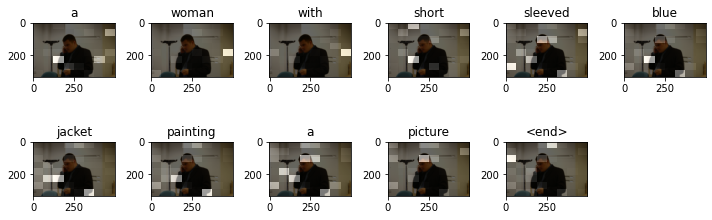

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/210126070.jpg
Real Caption: <start> a boy without a shirt on is jumping in the air almost upside down <end>
Prediction Caption: some people walking on a rocky expanse of some something <end>


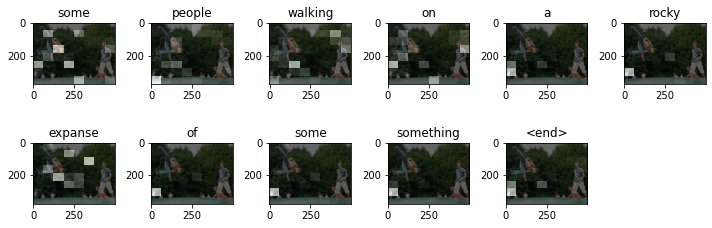

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/207015505.jpg
Real Caption: <start> people laughing and eating cotton candy <end>
Prediction Caption: a man in a striped shirt looks like having a grill while a smiling young women wearing a white blouse looks on the camera as younger women wearing blue shirt while a man in a white shirt looks to home their wedding colored bikini top chats while another man in a long sleeved shirt <end>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


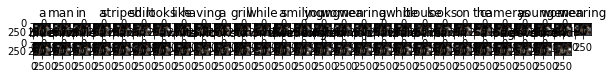

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/185411054.jpg
Real Caption: <start> five boys are <unk> in sand chest deep <end>
Prediction Caption: four sisters wearing swimming show their way that crashing in a sand <end>


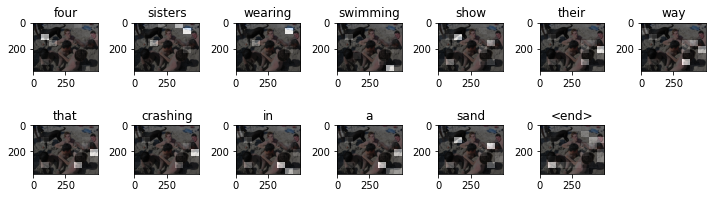

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/208820195.jpg
Real Caption: <start> a man is playing an instrument in a band <end>
Prediction Caption: a group of people are on a podium singing and having fun <end>


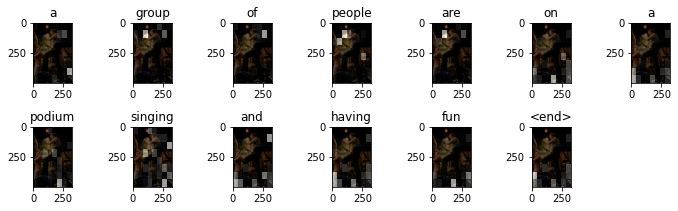

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/219730733.jpg
Real Caption: <start> a man is holding a young child 's hand at a fair <end>
Prediction Caption: a man wearing a black large building <end>


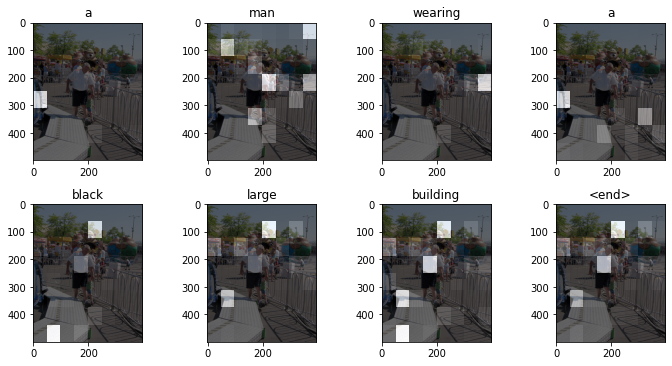

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/224702242.jpg
Real Caption: <start> a white dog jumps up to catch a soccer ball in <unk> grassy yard <end>
Prediction Caption: a man in a brown horse <end>


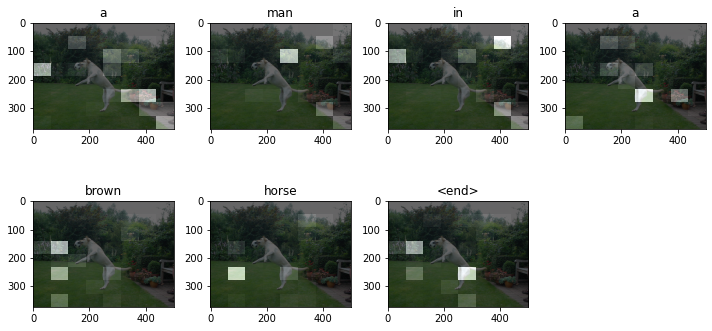

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/180146696.jpg
Real Caption: <start> a white truck is on a busy street <end>
Prediction Caption: several men with people before a man in a solicitor posing for a car <end>


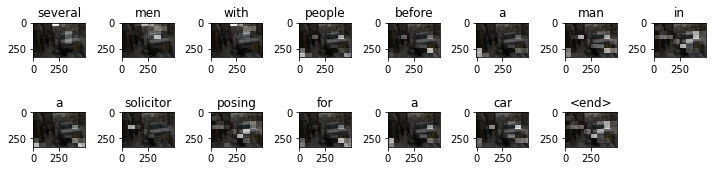

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/188552459.jpg
Real Caption: <start> boy in a black shirt standing in front of an advertisement <end>
Prediction Caption: a worker is wearing pink and watches a chain link fence <end>


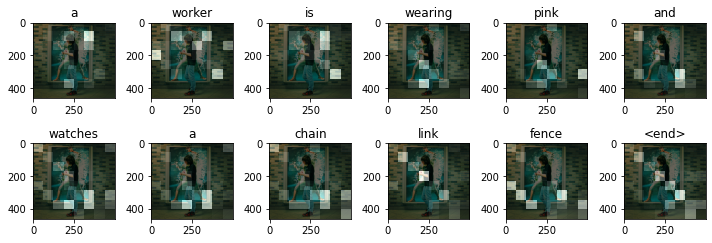

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/179486571.jpg
Real Caption: <start> guy walking two huge <unk> <end>
Prediction Caption: a child giving his hand <end>


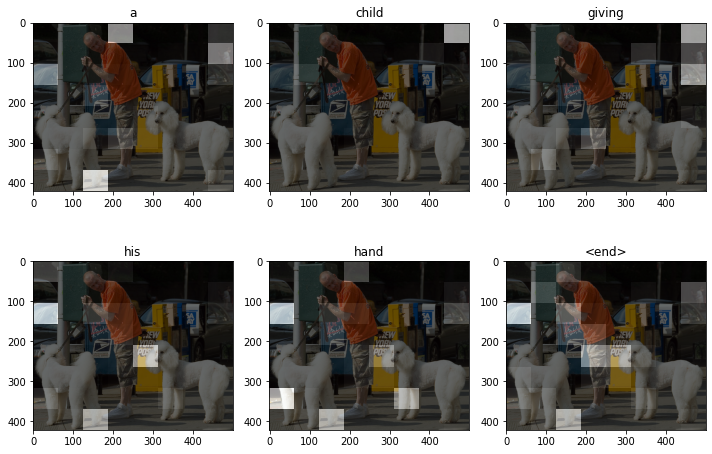

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/212863746.jpg
Real Caption: <start> two women are getting their pictures taken with a man in his underwear <end>
Prediction Caption: a woman walking by a large crowd <end>


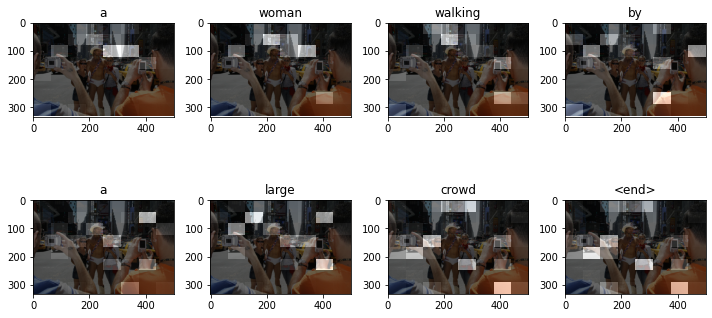

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/196523254.jpg
Real Caption: <start> a construction worker sitting in a bulldozer digging up dirt on a work site <end>
Prediction Caption: a man in an old building <end>


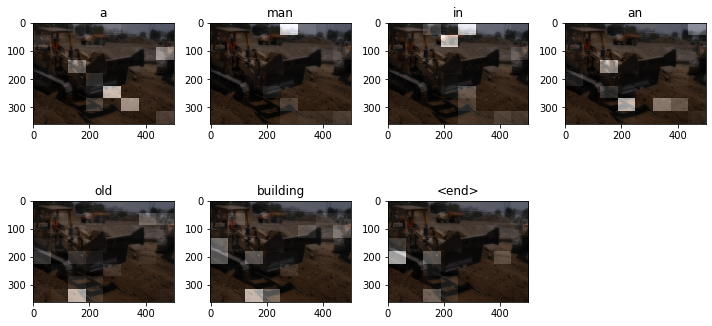

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/200778857.jpg
Real Caption: <start> the little boy is wearing sunglasses and kicking a soccer ball <end>
Prediction Caption: a young child wearing the left in the air <end>


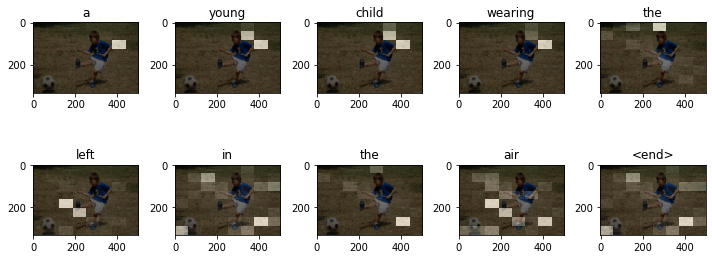

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/191003284.jpg
Real Caption: <start> a man helps a young girl balance on a bicycle that is too big for her <end>
Prediction Caption: a black man is posing for a man and a man in black pants carries a sign <end>


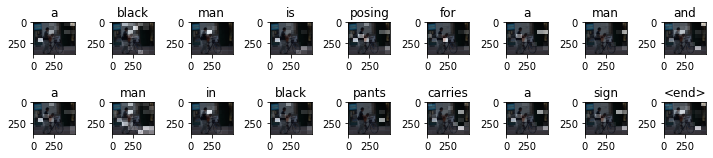

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/195193694.jpg
Real Caption: <start> people skating at a rollerskating rink <end>
Prediction Caption: a couple are seated on stage <end>


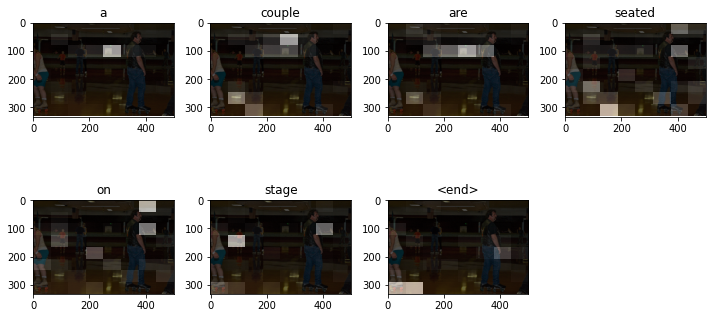

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/217583047.jpg
Real Caption: <start> a man in a white boat is rowing through fog <end>
Prediction Caption: a man in dark boat <end>


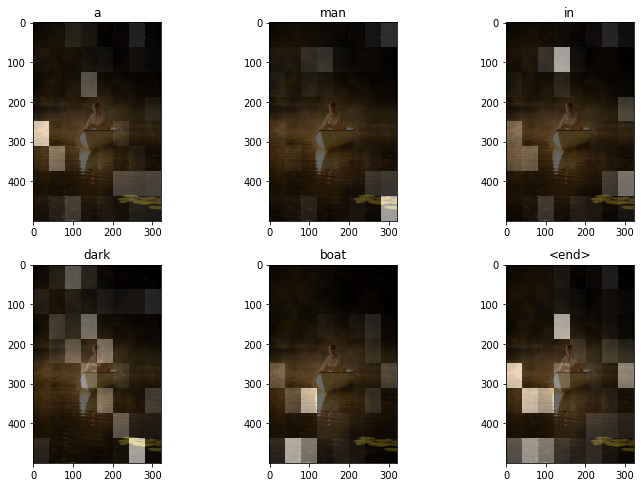

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/194704310.jpg
Real Caption: <start> a group of construction workers building a house <end>
Prediction Caption: people are walking <end>


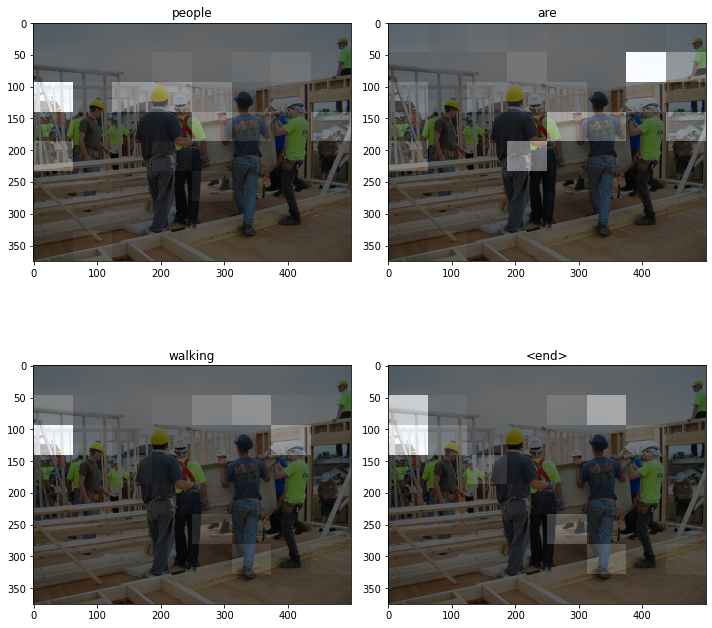

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/181157221.jpg
Real Caption: <start> two dogs on <unk> <unk> toward each other while their <unk> walk away from each other <end>
Prediction Caption: two girls dressed in tracksuits jumping in a field talking <end>


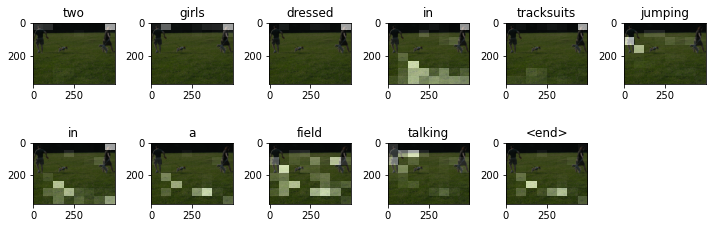

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/226115048.jpg
Real Caption: <start> a man having a beer and roasting a hotdog the old fashioned way on a stick over a fire pit <end>
Prediction Caption: a man wearing a gray jacket looks out <end>


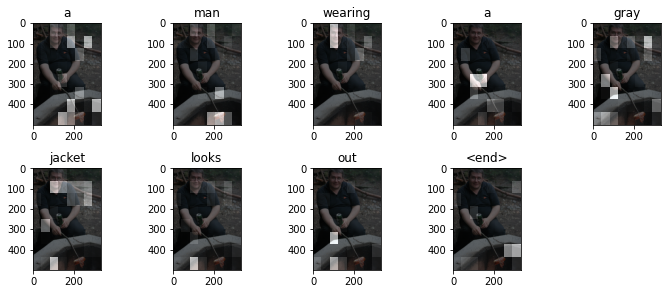

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/197924859.jpg
Real Caption: <start> a man uses an outdoor shower <end>
Prediction Caption: a little blond child dressed in black red hair and a checkered hat is sleeping on the help him blowing up at a sink <end>


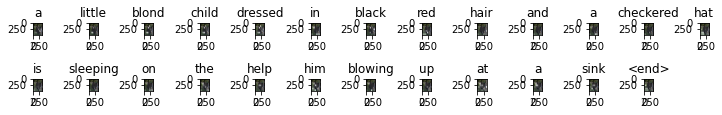

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/202174998.jpg
Real Caption: <start> five people on a hiking trip in a mountain range wearing harnesses and climbing equipment four with blue helmets and three smiling <end>
Prediction Caption: two men are having fun and having fun at a stone trail <end>


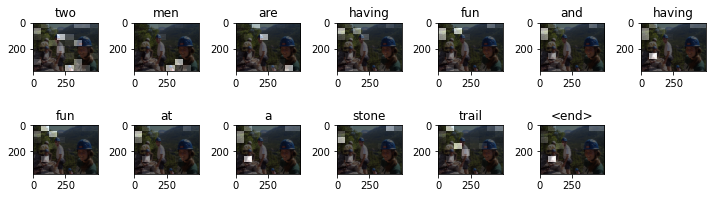

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/218483471.jpg
Real Caption: <start> a woman is balancing several items on her head that are in bags <end>
Prediction Caption: a man with yellow hair that is doing a white hat sits with a red baseball cap is in a room with toys <end>


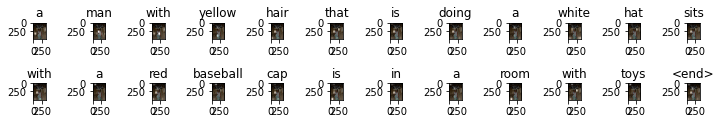

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/221063801.jpg
Real Caption: <start> two people dressed in costumes walk near a poster that says <unk> <unk> <end>
Prediction Caption: a large boy with a guy with a covering kick his back at a board racket <end>


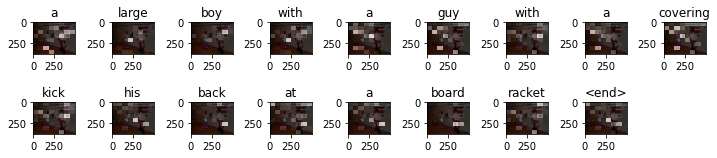

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/203792206.jpg
Real Caption: <start> man is diving off of a diving board into a built in pool <end>
Prediction Caption: a child is being visor and vest is riding around a wave <end>


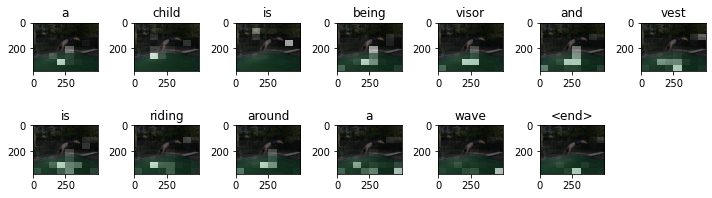

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/214815592.jpg
Real Caption: <start> a woman at a restaurant eating a dish of food <end>
Prediction Caption: a woman and one girl is talking <end>


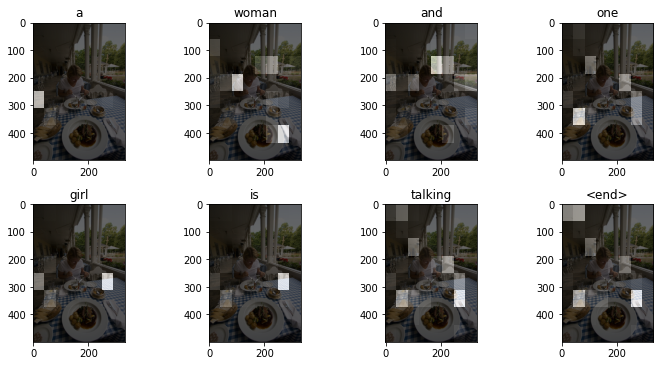

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/189519520.jpg
Real Caption: <start> two young men and a woman carrying an infant are gathered around a stand of watermelons <end>
Prediction Caption: a group of people sitting outside on a christmas scene <end>


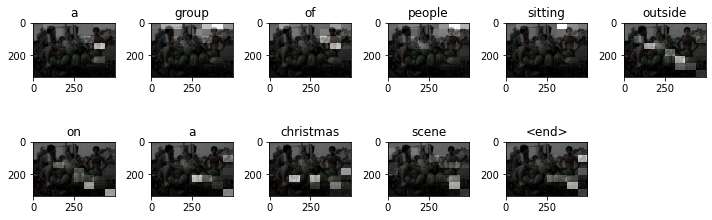

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/181989658.jpg
Real Caption: <start> a woman is walking with her cellphone while carrying a huge mannequin <end>
Prediction Caption: a man in pink blue bag <end>


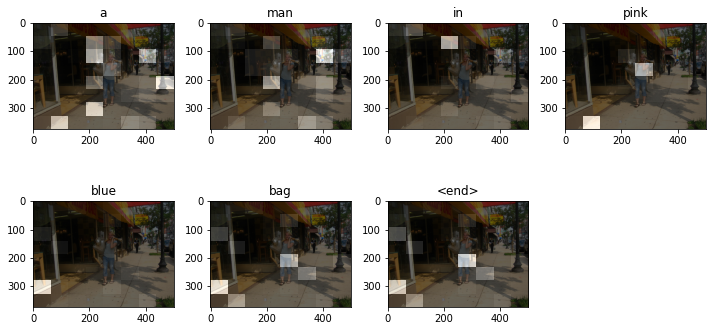

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/207930963.jpg
Real Caption: <start> a man wearing dirt bike clothes with a logo in closeup <end>
Prediction Caption: a person is on stairs at a bald man with a fat man wearing an open horse parked on a left hand food <end>


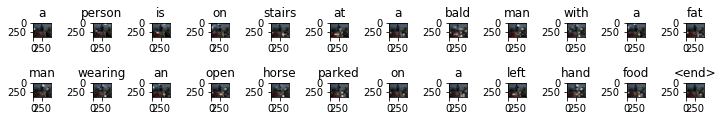

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/199604929.jpg
Real Caption: <start> some children are performing <unk> moves <end>
Prediction Caption: a group of people are with long shirts standing in front and one with martial arts class <end>


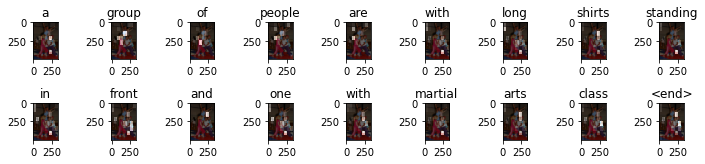

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/192305414.jpg
Real Caption: <start> a mother <unk> her school aged son in her arms <end>
Prediction Caption: a happy man in protective <end>


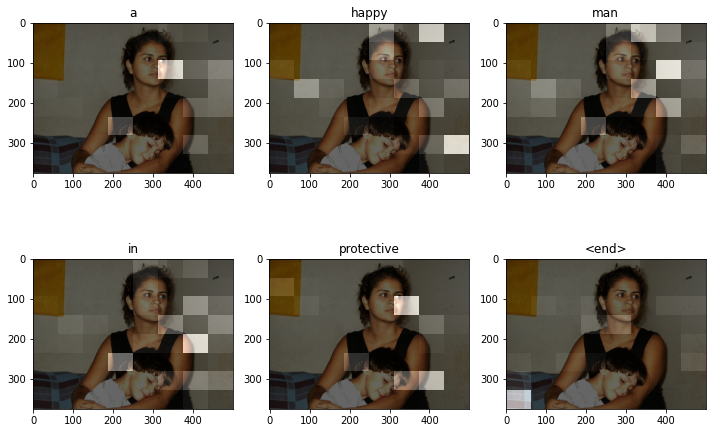

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/226634003.jpg
Real Caption: <start> two women walking arm in arm down the street toward a jewelery store <end>
Prediction Caption: a man cruises down the camera for a camera is standing on the shade to the younger woman <end>


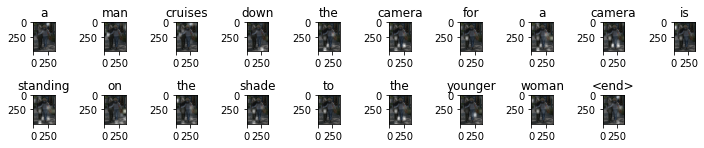

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/211341511.jpg
Real Caption: <start> a young girl in a yellow jersey is holding a <unk> on her arm while a man in a hat interviews her using a microphone <end>
Prediction Caption: a child dressed in costumes <end>


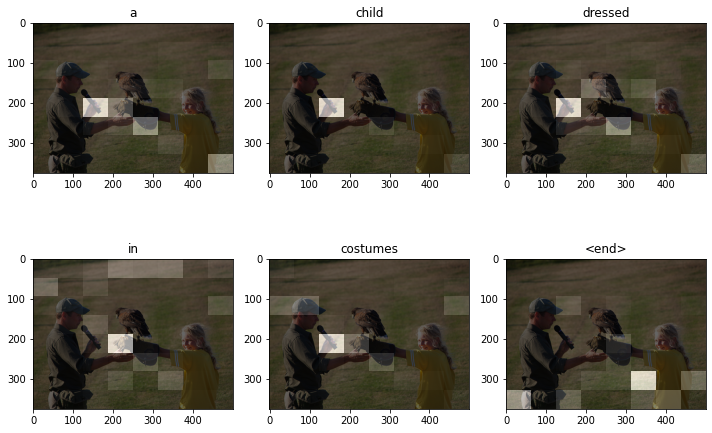

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/193945487.jpg
Real Caption: <start> girl playing <unk> golf with flowers in the background <end>
Prediction Caption: a woman is walking over four pipe in a tree for construction <end>


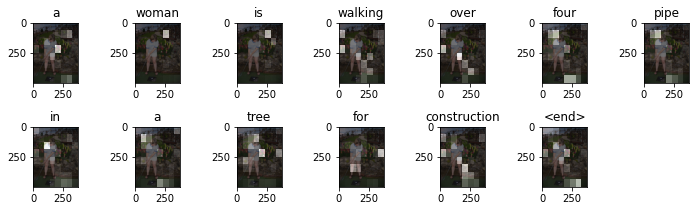

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/213836461.jpg
Real Caption: <start> cowboy turns back to wave out of the <unk> at a rodeo <end>
Prediction Caption: a group of men in camouflage are playing with a live animal in the person on dirt up a ball <end>


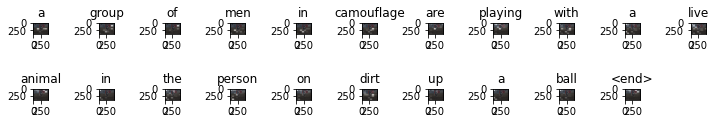

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/205682549.jpg
Real Caption: <start> a hiker standing on a bluff high in the mountains <end>
Prediction Caption: a man climbing a rock cliff going to climb a rock trail <end>


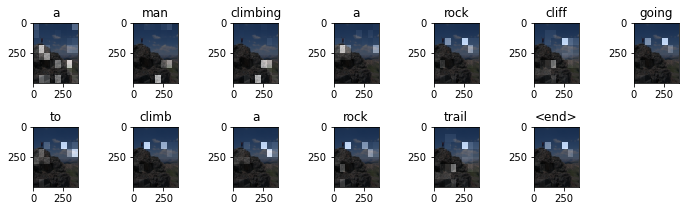

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/186890605.jpg
Real Caption: <start> a guy in swimming trunks flying on a rope swing above a lake <end>
Prediction Caption: a man is a black man stands on a long nets by his bike while a young man stands beside a boat <end>


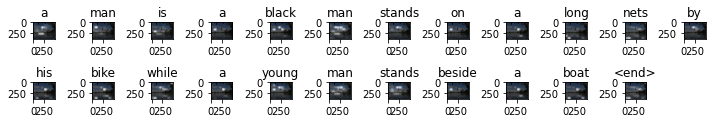

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/216308314.jpg
Real Caption: <start> two men riding scooters through an office <end>
Prediction Caption: a man in a pink laptop tongue out of a brown laptop chairs and the camera <end>


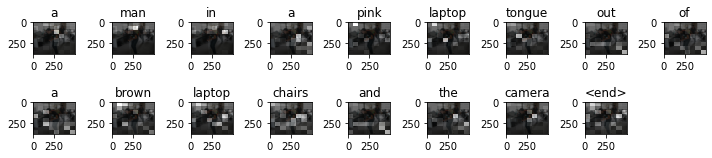

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/222369445.jpg
Real Caption: <start> two <unk> carry their boards to the end of a walkway to join the others in the water <end>
Prediction Caption: a man talking on the edge of an ocean <end>


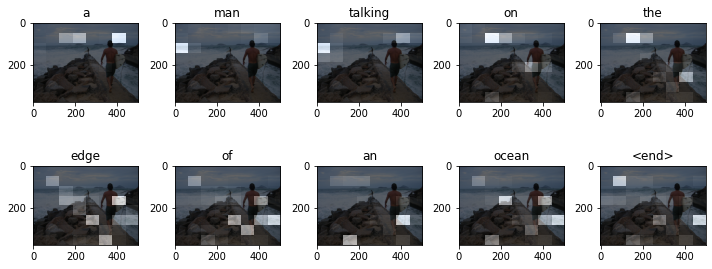

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/183018056.jpg
Real Caption: <start> there is a parade going on in the street a group of people are holding up an <unk> the <unk> float device <end>
Prediction Caption: a person is walking with two liters of the camera along the middle of a railroad car <end>


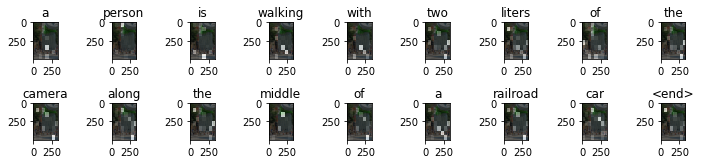

/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/223761052.jpg
Real Caption: <start> two men working on a car with a big red jack in front of it <end>
Prediction Caption: a protester and they look on the middle of a presentation in front of a white are wearing white pants stands up while others are watching a man selling watermelon <end>


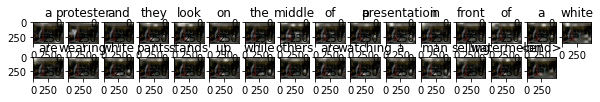

In [ ]:
# captions on the validation set
#fpath = f'/content/drive/MyDrive/image_captioning_data/{NAME}/val_vectors/'
#query = fpath + '*_{}_*'.format(IMAGE_MODEL)
#fpath = glob(query)

#data = np.load(np.random.choice(fpath), allow_pickle=True)[()]
#rid = np.random.choice(90)
#X, y = data['X'].numpy()[rid], data['y'][rid]
reid = re.compile(r'\d{12}')
a = glob(f'/content/drive/MyDrive/image_captioning_data/{NAME}/val_vectors/val_{IMAGE_MODEL}*')
for aa in a:
    data = np.load(aa, allow_pickle=True)[()]
    X, y = data['X'].numpy()[0], data['y'][0]
    if NAME == 'COCO':
        iid = reid.findall(aa)[0]
        image_id = f'/content/drive/MyDrive/image_captioning_data/COCO/val_images/COCO_train2014_{iid}.jpg'
    else:
        iid = reid.findall(aa)[0].lstrip('0')
        image_id = f'/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/{iid}.jpg'

    real_caption = ' '.join([tokenizer.index_word[i]
                        for i in y if i not in [0]])
    result, attention_plot = evaluate(X)
    print(image_id)
    print('Real Caption:', real_caption)
    print('Prediction Caption:', ' '.join(result))
    plot_attention(image_id, result, attention_plot)

In [ ]:
val_data_files = glob(f'/content/drive/MyDrive/image_captioning_data/{NAME}/val_vectors/val_{IMAGE_MODEL}*')

real = []
prediction = []
for v in val_data_files:
    data = np.load(v, allow_pickle=True)[()]
    for x, y in zip(data['X'].numpy(), data['y']):
        real.append(' '.join([tokenizer.index_word[i]
                        for i in y if i not in [0]]))
        result, _ = evaluate(x)
        prediction.append(' '.join(result))


In [ ]:
def sub_tok(x):
    x = re.sub('<start>', '', x)
    x = re.sub('<end>', '', x)
    return x

In [ ]:
real = [sub_tok(i) for i in real]
prediction = [sub_tok(i) for i in real]


In [ ]:
#real = [i.split() for i in real]
#prediction = [i.split() for i in prediction]

In [ ]:
np.save(f'/content/drive/MyDrive/image_captioning_data/{NAME}/{NAME}_{IMAGE_MODEL}_pred.npy', 
        {'real': real, 'pred': prediction})